# Digit Recognizer

Target: Take an image of a handwritten single digit, and determine what that digit is.

Source: https://www.kaggle.com/c/digit-recognizer

In [1]:
# data manipulation
import numpy as np
import pandas as pd
import random

# high-level neural networks API - running on top of TensorFlow
import keras
# Sequential is a linear stack of layers
from keras.models import Sequential
# Dense, Flatten - type of layers, Dropout - tool, which decrease chance of overfitting
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K

# data visualisation, live training loss plot
import matplotlib.pyplot as plt
import livelossplot

import time
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [2]:
# load dataset
train = pd.read_csv("input/train.csv")
test = pd.read_csv("input/test.csv")

In [3]:
y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

In [4]:
# shape of data
X_train.shape

(42000, 784)

In [5]:
def vis_rand_dig():
    # size of pixcel
    plt.figure(figsize = (10, 10))
    # print random digit
    rand_indexes = np.random.randint(0, X_train.shape[0], 16)
    for index,im_index in enumerate(rand_indexes):
        plt.subplot(4, 4, index+1)
        plt.imshow(X_train.values[im_index].reshape(28,28), cmap = 'ocean', interpolation = 'none')
        plt.title('Class %d' % y_train[im_index])
    plt.tight_layout()

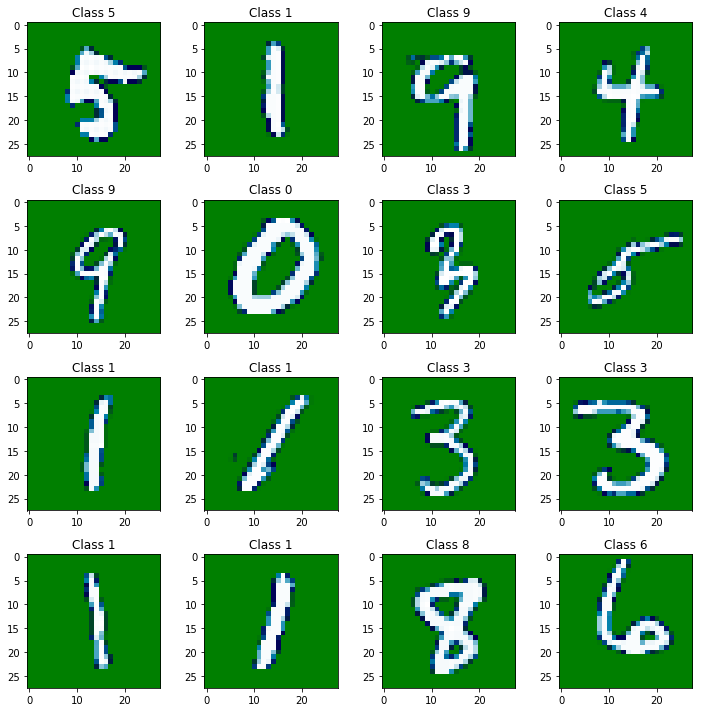

In [6]:
vis_rand_dig()

# CNN

Convolutional neural network expects additional parameter - number of channels. In computer science we have two type of standards. We may add channel at the first or last element. It is dependent on backend. I use TensorFlow, so I add channel at last.

In [7]:
def prep_data(X_train, y_train, test):
   
    X_train = X_train.astype('float32') / 255
    test = test.astype('float32')/255
    X_train = X_train.values.reshape(-1,28,28,1)
    test = test.values.reshape(-1,28,28,1)
    y_train = keras.utils.np_utils.to_categorical(y_train)
    classes = y_train.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state = int(time.time()))
    
    return X_train, y_train, X_test, y_test, classes, test

In [8]:
X_train, y_train, X_test, y_test, out_neurons, test = prep_data(X_train, y_train, test)

In [9]:
def cnn():
    cnn = Sequential([
        Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (28,28,1)),
        Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Flatten(),
        
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(256, activation = 'relu'),
        Dropout(0.5),
        Dense(out_neurons, activation = 'softmax')
    ])
    return cnn

model = cnn()
model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam' , metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

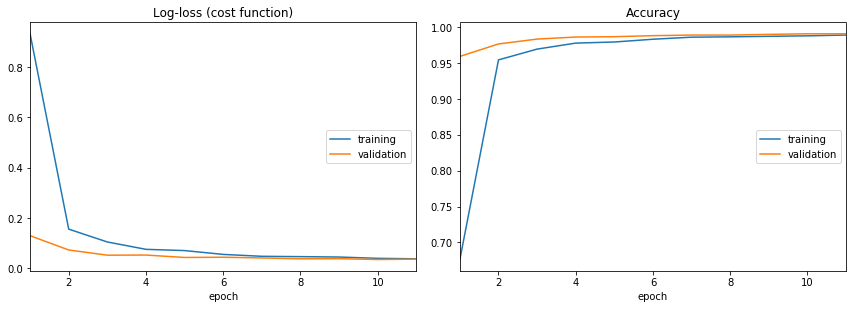

Log-loss (cost function):
training   (min:    0.038, max:    0.933, cur:    0.038)
validation (min:    0.035, max:    0.130, cur:    0.036)

Accuracy:
training   (min:    0.676, max:    0.989, cur:    0.989)
validation (min:    0.959, max:    0.991, cur:    0.991)
CPU times: user 41.9 s, sys: 7.97 s, total: 49.9 s
Wall time: 1min 2s


In [10]:
%%time
# learning curve, which draws live
# https://github.com/stared/livelossplot 

plot_losses = livelossplot.PlotLossesKeras()

model.fit(X_train, y_train,
          batch_size = 512,
          epochs = 11,
          validation_data = (X_test, y_test),
          callbacks = [plot_losses],
          verbose = 0);

In [11]:
result = model.evaluate(X_test, y_test, verbose = 0)
print('Accuracy: ', result[1])
print('Error: %.2f%%' % (100- result[1]*100))

Accuracy:  0.9907142857142858
Error: 0.93%


# Where we have mistake?

In [12]:
y_pred = model.predict(test, verbose=0)

In [13]:
def error_predict(y_test, y_pred):
    for idx, (a, b) in enumerate(zip(y_test, y_pred)):
        if np.argmax(a) == np.argmax(b): continue
        yield idx, np.argmax(a), tuple(np.argsort(b)[-2:])

In [14]:
def display_errors():
    random_errors = random.sample(list(error_predict(y_test, y_pred)), 12)

    plt.figure(figsize=(10, 10))
    X_test_plot = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2] )

    for index, (im_index, y_test_val, (y_pred_2, y_pred_1)) in enumerate(random_errors):
            plt.subplot(4,4,index+1)
            plt.imshow(X_test_plot[im_index], cmap='ocean', interpolation='none')
            plt.title('True value: {0}\nFirst predicted: {1}\nSecond predicted: {2}'.format(y_test_val, y_pred_1, y_pred_2))
            plt.tight_layout()

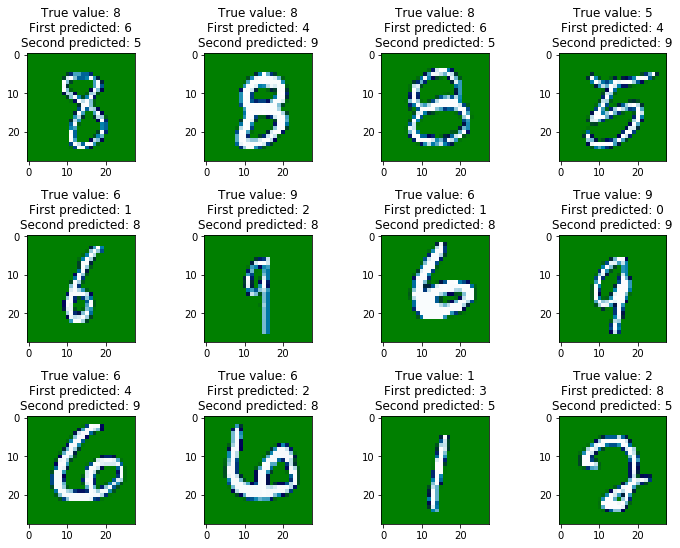

In [15]:
display_errors()

In my opiniom model make mistake in very difficult cases.

# Conclusions

- The best score: 0.9952(accuracy), 0,48%(error);
- The best architecture of CNN: 
        Conv2D(32, kernel_size = (3, 3), padding = 'same', activation = 'relu',
                input_shape = in_dim),
        Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        Conv2D(128, kernel_size = (3, 3), activation = 'relu', padding = 'same'),
        MaxPool2D(pool_size = (2, 2)),
        Dropout(0.25),
        
        Flatten(),
        
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(256, activation = 'relu'),
        Dropout(0.5),
        Dense(out_dim, activation = 'softmax')
        
- Parameters: 1,010,666;
- Time: 16 min 47 s;
- Hardware: CPU - Ryzen 2700X  (I know that GPU is better for deep learning, but I didn't have opportunity to work on GPU);
- Batch size: 512;
- Epochs: 11;

I tried several configuration. The results varied between 0,48% - 0,84% (error). Generally I changed number of layers, number of kernels, size of batch_size and number of epochs. 
I noticed, that: 
- More layer increased computing time and growing number of parameters;
- More batch_size affect the reduced computing time;
- More expanded section of MLP (number of layers and number of neurones) influences on more parameters;
- More CNN layers = less parameters;
- More numbers of epochs affect on growing compute time;
- Worse score after used BatchNormalization;
- CNN vs MLP for digit recognition? Decisively CNN for digit recognizer!

In [16]:
solution = np.argmax(y_pred,axis = 1)
solution = pd.Series(solution, name="Label").astype(int)
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),solution],axis = 1)
submission.to_csv("mnist_cnn.csv",index=False)